In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 21.96 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [3]:
cd observations/mask_classifier/

/content/observations/mask_classifier


In [4]:
!pip3 install -r requirements.txt.

     |████████████████████████████████| 104 kB 4.3 MB/s 
     |████████████████████████████████| 103 kB 30.2 MB/s 
     |████████████████████████████████| 106 kB 39.0 MB/s 
     |████████████████████████████████| 157 kB 55.6 MB/s 
     |████████████████████████████████| 3.2 MB 59.8 MB/s 
     |████████████████████████████████| 88 kB 9.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 156 kB 68.6 MB/s 
     |████████████████████████████████| 400 kB 72.9 MB/s 
     |████████████████████████████████| 82 kB 1.6 MB/s 
     |████████████████████████████████| 2.3 MB 63.7 MB/s 
     |████████████████████████████████| 237 kB 93.5 MB/s 
ERROR: Could not find a version that satisfies the requirement glob3==0.0.1 (from versions: none)
ERROR: No matching distribution found for glob3==0.0.1


In [5]:
pip install face_recognition

     |████████████████████████████████| 100.1 MB 12 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=9937d4d050d1cb3a1661dad027b3d9d834d70f93a7736e8e9d207e0dc70ac996
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [6]:
import os
import sys
import random
import argparse
import numpy as np
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import face_recognition

In [7]:
IMAGE_DIR = os.path.join(os.path.dirname(os.path.abspath('/content/observations/mask_classifier/Data_Generator/images')), 'images')

In [8]:
IMAGE_DIR

'/content/observations/mask_classifier/Data_Generator/images'

In [58]:
face_image_np = face_recognition.load_image_file('/content/observations/experiements/data/without_mask/2.jpg')

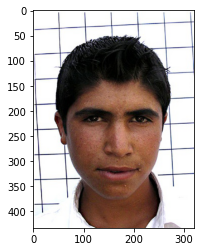

In [59]:
plt.imshow(face_image_np)

In [82]:
face_locations = face_recognition.face_locations(face_image_np, model='hog')

In [83]:
face_locations

[(180, 262, 366, 77)]

In [84]:
face_landmarks = face_recognition.face_landmarks(face_image_np, face_locations)

In [85]:
_face_img = Image.fromarray(face_image_np)
_mask_img = Image.open('/content/observations/mask_classifier/Data_Generator/images/blue-mask.png')

In [86]:
face_path = '/content/observations/experiements/data/without_mask/1.jpg'

In [87]:
def _save():
  path_splits = os.path.splitext(face_path)
  new_face_path = path_splits[0] + '-with-mask' + path_splits[1]
  _face_img.save(new_face_path)
  print(f'Save to {new_face_path}')

 

  
def _mask_face(face_landmark: dict):
  nose_bridge = face_landmark['nose_bridge']
  nose_point = nose_bridge[len(nose_bridge) * 1 // 4]
  nose_v = np.array(nose_point)

  chin = face_landmark['chin']
  chin_len = len(chin)
  chin_bottom_point = chin[chin_len // 2]
  chin_bottom_v = np.array(chin_bottom_point)
  chin_left_point = chin[chin_len // 8]
  chin_right_point = chin[chin_len * 7 // 8]

  # split mask and resize
  width = _mask_img.width
  height = _mask_img.height
  width_ratio = 1.2
  new_height = int(np.linalg.norm(nose_v - chin_bottom_v))

  # left
  mask_left_img = _mask_img.crop((0, 0, width // 2, height))
  mask_left_width = get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)
  mask_left_width = int(mask_left_width * width_ratio)
  mask_left_img = mask_left_img.resize((mask_left_width, new_height))

  # right
  mask_right_img = _mask_img.crop((width // 2, 0, width, height))
  mask_right_width = get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)
  mask_right_width = int(mask_right_width * width_ratio)
  mask_right_img = mask_right_img.resize((mask_right_width, new_height))

  # merge mask
  size = (mask_left_img.width + mask_right_img.width, new_height)
  mask_img = Image.new('RGBA', size)
  mask_img.paste(mask_left_img, (0, 0), mask_left_img)
  mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

  # rotate mask
  angle = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
  rotated_mask_img = mask_img.rotate(angle, expand=True)

  # calculate mask location
  center_x = (nose_point[0] + chin_bottom_point[0]) // 2
  center_y = (nose_point[1]- 100 + chin_bottom_point[1]) // 2

  offset = mask_img.width // 2 - mask_left_img.width
  radian = angle * np.pi / 180
  box_x = center_x + int(offset * np.cos(radian)) - rotated_mask_img.width // 2
  box_y = center_y + int(offset * np.sin(radian)) - rotated_mask_img.height // 2

  # add mask
  _face_img.paste(mask_img, (box_x, box_y), mask_img)


def get_distance_from_point_to_line(point, line_point1, line_point2):
  distance = np.abs((line_point2[1] - line_point1[1]) * point[0] +
                    (line_point1[0] - line_point2[0]) * point[1] +
                    (line_point2[0] - line_point1[0]) * line_point1[1] +
                    (line_point1[1] - line_point2[1]) * line_point1[0]) / \
              np.sqrt((line_point2[1] - line_point1[1]) * (line_point2[1] - line_point1[1]) +
                      (line_point1[0] - line_point2[0]) * (line_point1[0] - line_point2[0]))
  return int(distance)  

In [88]:
KEY_FACIAL_FEATURES = ('nose_bridge', 'chin')  #FACE. EYES.NOSE. EARS .MOUTH. TEETH.CHIN .HAIR.
show = False
for face_landmark in face_landmarks:
    # check whether facial features meet requirement
    skip = False
    for facial_feature in KEY_FACIAL_FEATURES:
        if facial_feature not in face_landmark:
            skip = True
            break
    if skip:
        continue

    # mask face
    found_face = True
    _mask_face(face_landmark)
    print('end')

if found_face:
  if show:
      _face_img.show()

  # save
  _save()
else:
  print('Found no face.')

end
Save to /content/observations/experiements/data/without_mask/1-with-mask.jpg


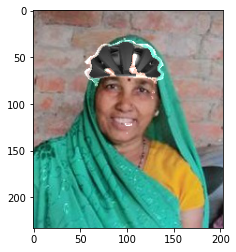

In [178]:
reuslt = plt.imshow(result)

In [188]:
plt.imsave('res.jpeg',result)

In [169]:
res = face_recognition.load_image_file('/content/observations/experiements/data/without_mask/1-with-mask.jpg')
plt.imshow(res)

FileNotFoundError: ignored

In [49]:
5 // 3

1

In [50]:
pwd

'/content/observations/mask_classifier'

In [51]:
# cd /content/

In [52]:
# !bunzip2  -dkv shape_predictor_68_face_landmarks.dat.bz2

In [229]:
len(os.listdir('/content/drive/MyDrive/tw/train_h/'))

554

In [224]:
import cv2, dlib, sys
import numpy as np
from tqdm import tqdm

dir = os.listdir('/content/observations/experiements/data/without_mask')

def _save(face_path, _face_img):
  path_splits = os.path.splitext(face_path)
  appa = path_splits[0].split('/')[-1]
  new_face_path =f'/content/drive/MyDrive/tw/train_h/{appa}' + '-with-helmet' + path_splits[1]
  plt.imsave(new_face_path,_face_img)
  

def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
  try:
    bg_img = background_img.copy()
    # convert 3 channels to 4 channels
    if bg_img.shape[2] == 3:
      bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2BGRA)

    if overlay_size is not None:
      img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

    b, g, r, a = cv2.split(img_to_overlay_t)

    mask = cv2.medianBlur(a, 5)

    h, w, _ = img_to_overlay_t.shape
    roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
  
    img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)
  
    bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)
  
    # convert 4 channels to 4 channels
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGRA2BGR)

    return bg_img
  except Exception:return background_img

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/tw/face_landmark/shape_predictor_68_face_landmarks.dat')

for i in tqdm(dir):
  scaler = 1
  face_path = f'/content/observations/experiements/data/without_mask/{i}'
  
  try:
    face_image_np = face_recognition.load_image_file(face_path)
  except:
    print(f'??실패??{i}')
    continue

  # initialize face detector and shape predictor
  
  # load video
  cap = face_image_np
  # load overlay image
  overlay = cv2.imread('/content/drive/MyDrive/tw/helmet/transparent.png', cv2.IMREAD_UNCHANGED)

  face_roi = []
  face_sizes = []

  # loop
  # read frame buffer from video
  img = cap

  # resize frame
  img = cv2.resize(img, (int(img.shape[1] * scaler), int(img.shape[0] * scaler)))
  ori = img.copy()
  roi_img = img.copy()

  # find faces
  faces = detector(img,1)
  # if len(face_roi) == 0:
  #   faces = detector(img, 1)
  # else:
  #   roi_img = img #[face_roi[0]:face_roi[1], face_roi[2]:face_roi[3]]
  #   # cv2.imshow('roi', roi_img)
  #   faces = detector(roi_img)

  # no faces
  if len(faces) == 0:
    print('no faces!')
    print(f'Save to {i}')
    continue

  # find facial landmarks
  for face in faces:
    if len(face_roi) == 0:
      dlib_shape = predictor(img, face)
      shape_2d = np.array([[p.x, p.y] for p in dlib_shape.parts()])
    else:
      dlib_shape = predictor(roi_img, face)
      shape_2d = np.array([[p.x + face_roi[2], p.y + face_roi[0]] for p in dlib_shape.parts()])

    for s in shape_2d:
      cv2.circle(img, center=tuple(s), radius=1, color=(255, 255, 255), thickness=2, lineType=cv2.LINE_AA)

  # compute face center
  center_x, center_y = np.mean(shape_2d, axis=0).astype(np.int)

  # compute face boundaries
  min_coords = np.min(shape_2d, axis=0)
  max_coords = np.max(shape_2d, axis=0)

  # draw min, max coords
  cv2.circle(img, center=tuple(min_coords), radius=1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
  cv2.circle(img, center=tuple(max_coords), radius=1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)

  # compute face size
  face_size = max(max_coords - min_coords)
  face_sizes.append(face_size)
  if len(face_sizes) > 10:
    del face_sizes[0]
  mean_face_size = int(np.mean(face_sizes) * 1)    # 크기 조절구간@@@@@@@@@@@@@@@@@@@@@@@@

  # compute face roi
  face_roi = np.array([int(min_coords[1] - face_size / 2), int(max_coords[1] + face_size / 2), int(min_coords[0] - face_size / 2), int(max_coords[0] + face_size / 2)])
  face_roi = np.clip(face_roi, 0, 10000)

  # draw overlay on face  위치조절 가능 구간@@@@@@@@@@@@@@@@@@@@@@@@@@@@
  result = overlay_transparent(ori, overlay, center_x , center_y - int(face_size*0.3) , overlay_size=(int(mean_face_size*1.2)  , int(mean_face_size*1.4) ))

  # visualize
  # plt.imshow( ori)
  # plt.imshow( img)
  # plt.imshow(result)
  _save(face_path, result)



  3%|▎         | 23/687 [00:03<01:09,  9.52it/s]

no faces!
Save to augmented_image_87.jpg


  4%|▍         | 27/687 [00:03<01:15,  8.73it/s]

no faces!
Save to augmented_image_85.jpg


 14%|█▎        | 94/687 [00:11<01:04,  9.19it/s]

no faces!
Save to augmented_image_3.jpg


 15%|█▌        | 105/687 [00:12<00:52, 11.17it/s]

no faces!
Save to 354.jpg


 21%|██▏       | 146/687 [00:16<01:13,  7.33it/s]

no faces!
Save to 188.jpg


 26%|██▌       | 176/687 [00:19<00:41, 12.31it/s]

??실패??.ipynb_checkpoints


 28%|██▊       | 193/687 [00:22<00:53,  9.17it/s]

no faces!
Save to 389.jpg
no faces!
Save to augmented_image_99.jpg


 32%|███▏      | 221/687 [00:25<00:44, 10.41it/s]

no faces!
Save to augmented_image_7.jpg


 43%|████▎     | 292/687 [00:34<01:33,  4.24it/s]

no faces!
Save to augmented_image_180.jpg


 46%|████▌     | 315/687 [00:36<00:31, 11.79it/s]

no faces!
Save to augmented_image_151.jpg


 52%|█████▏    | 359/687 [00:41<00:48,  6.82it/s]

no faces!
Save to augmented_image_79.jpg


 55%|█████▍    | 376/687 [00:43<00:23, 13.34it/s]

no faces!
Save to augmented_image_84.jpg
no faces!
Save to augmented_image_30.jpg


 58%|█████▊    | 398/687 [00:45<00:39,  7.39it/s]

no faces!
Save to augmented_image_35.jpg


 67%|██████▋   | 463/687 [00:52<00:25,  8.69it/s]

no faces!
Save to augmented_image_181.jpg


 70%|██████▉   | 478/687 [00:53<00:16, 12.89it/s]

no faces!
Save to augmented_image_86.jpg


 71%|███████   | 486/687 [00:54<00:20, 10.00it/s]

no faces!
Save to augmented_image_98.jpg


 73%|███████▎  | 504/687 [00:57<00:35,  5.09it/s]

no faces!
Save to augmented_image_82.jpg


 76%|███████▌  | 523/687 [00:59<00:19,  8.39it/s]

no faces!
Save to augmented_image_4.jpg


 77%|███████▋  | 527/687 [00:59<00:16,  9.88it/s]

no faces!
Save to augmented_image_83.jpg


 82%|████████▏ | 564/687 [01:05<00:11, 10.43it/s]

no faces!
Save to augmented_image_152.jpg


 84%|████████▎ | 574/687 [01:06<00:12,  8.94it/s]

no faces!
Save to 28.jpg


 84%|████████▍ | 579/687 [01:06<00:09, 11.40it/s]

no faces!
Save to augmented_image_5.jpg


 87%|████████▋ | 599/687 [01:08<00:09,  9.72it/s]

no faces!
Save to augmented_image_296.jpg


 89%|████████▉ | 610/687 [01:10<00:13,  5.56it/s]

no faces!
Save to augmented_image_178.jpg


100%|██████████| 687/687 [01:19<00:00,  8.67it/s]


In [213]:
detector(img, 1)

rectangles[[(43, 118) (266, 341)], [(221, 2) (257, 38)], [(125, 2) (161, 38)]]

In [228]:
dir = os.listdir('/content/observations/experiements/data/without_mask')

def _save_(face_path, _face_img):
  path_splits = os.path.splitext(face_path)
  appa = path_splits[0].split('/')[-1]
  new_face_path =f'/content/drive/MyDrive/tw/train_/{appa}' + '-no-helmet' + path_splits[1]
  plt.imsave(new_face_path,_face_img)
  
for i in tqdm(dir):
  face_path = f'/content/observations/experiements/data/without_mask/{i}'
  try:
    face_image_np = face_recognition.load_image_file(face_path)
  except:
    print(f'??실패??{i}')
    continue
  _save_(face_path, face_image_np)

 26%|██▌       | 179/687 [00:02<00:06, 83.74it/s]

??실패??.ipynb_checkpoints


100%|██████████| 687/687 [00:09<00:00, 74.90it/s]


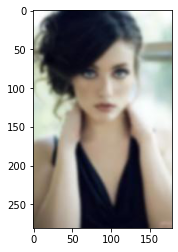

In [227]:
plt.imshow(face_recognition.load_image_file('/content/observations/experiements/data/without_mask/augmented_image_85.jpg'))

In [ ]:
import cv2
import os
from mask import create_mask


folder_path = "/home/preeth/Downloads"
#dist_path = "/home/preeth/Downloads"

#c = 0
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
for i in range(len(images)):
    print("the path of the image is", images[i])
    #image = cv2.imread(images[i])
    #c = c + 1
    create_mask(images[i])